In [2]:
import pandas as pd
import numpy as np
import os
import itertools
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import DaskLGBMClassifier
import seaborn as sns
from wordcloud import WordCloud

In [4]:
df = pd.read_csv('/content/drive/MyDrive/ML-Phishing Detection Project/data/additional_urls.csv')
print(df.shape)
df.head(10)

(450176, 4)


,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0
5,5,https://www.reddit.com,benign,0
6,6,https://www.yahoo.com,benign,0
7,7,https://www.google.co.in,benign,0
8,8,https://www.qq.com,benign,0
9,9,https://www.amazon.com,benign,0


In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('result', axis=1, inplace=True)
print(df.shape)
df

(450176, 2)


,url,label
0,https://www.google.com,benign
1,https://www.youtube.com,benign
2,https://www.facebook.com,benign
3,https://www.baidu.com,benign
4,https://www.wikipedia.org,benign
...,...,...
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious
450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious
450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious
450174,http://atualizapj.com/,malicious


In [4]:
#benign
#malicious

In [6]:
#df.value_counts()
df.label.value_counts()

benign       345738
malicious    104438
Name: label, dtype: int64

In [7]:
import re

def haveIP(url):
  match = re.search(
      '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
      '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'
      '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1-2})\\.(0x[0-9a-fA-F]{1,2})\\/)'
      '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}',url)

  if match:
    return 1
  else:
    return 0

df['HaveIP'] = df['url'].apply(lambda i : haveIP(i))

df.head(10)

,url,label,HaveIP
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0
5,https://www.reddit.com,benign,0
6,https://www.yahoo.com,benign,0
7,https://www.google.co.in,benign,0
8,https://www.qq.com,benign,0
9,https://www.amazon.com,benign,0


In [8]:
from urllib.parse import urlparse

def abnormal_url(url):
  hostname = urlparse(url).hostname
  hostname = str(hostname)
  print(url,"------>",hostname)
  try:
    match = re.search(hostname,url)

    if match:
      return 1
    else:
      return 0

  except:
    return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

df.head()

Streaming output truncated to the last 5000 lines.
https://sevappseilgoog.blogspot.com/ ------> sevappseilgoog.blogspot.com
https://teqsacb54f687b19support.blogspot.com/ ------> teqsacb54f687b19support.blogspot.com
http://ross.cd/kidsmovies/hp_s_ervice.html ------> ross.cd
http://perso.menara.ma/~zghari/notex/ ------> perso.menara.ma
http://viescas.com/Tips/language/_spea_ing6.html ------> viescas.com
http://www.angelfire.com/crazy/babyblue_princess543/babyblue/ ------> www.angelfire.com
http://caspianglobalservices.com/fonts/.hennessy/ ------> caspianglobalservices.com
http://d662653.u-telcom.net/west/ayo1/ayo1/ayo1/ ------> d662653.u-telcom.net
http://d662653.u-telcom.net/can/ayo1/ayo1/ayo1/ ------> d662653.u-telcom.net
http://123xsallowed.com/facebook001/index_1012145abdgjahdskjahjdhqiue54878akjdhkjashdhahdghjabgdfbhasbf21544878asdasndashdggashdg.htm ------> 123xsallowed.com
http://caspianglobalservices.com/awosoke/fud/formfix/form/ ------> caspianglobalservices.com
http://www.tinta

,url,label,HaveIP,abnormal_url
0,https://www.google.com,benign,0,1
1,https://www.youtube.com,benign,0,1
2,https://www.facebook.com,benign,0,1
3,https://www.baidu.com,benign,0,1
4,https://www.wikipedia.org,benign,0,1


In [9]:
!pip install googlesearch-python

In [10]:
from googlesearch import search
def IsGoogleIndex(url):
  site = search(url,5)
  if site:
    return 1
  else:
    return 0

df['IsGoogleIndex'] = df['url'].apply(lambda i : IsGoogleIndex(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex
0,https://www.google.com,benign,0,1,1
1,https://www.youtube.com,benign,0,1,1
2,https://www.facebook.com,benign,0,1,1
3,https://www.baidu.com,benign,0,1,1
4,https://www.wikipedia.org,benign,0,1,1


In [11]:
def dot_count(url):
  count = url.count('.')
  return count

df['dot_count'] = df['url'].apply(lambda i : IsGoogleIndex(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count
0,https://www.google.com,benign,0,1,1,1
1,https://www.youtube.com,benign,0,1,1,1
2,https://www.facebook.com,benign,0,1,1,1
3,https://www.baidu.com,benign,0,1,1,1
4,https://www.wikipedia.org,benign,0,1,1,1


In [12]:
def count_www(url):
  count = url.count('www')
  return count

df['count_www'] = df['url'].apply(lambda i :count_www(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www
0,https://www.google.com,benign,0,1,1,1,1
1,https://www.youtube.com,benign,0,1,1,1,1
2,https://www.facebook.com,benign,0,1,1,1,1
3,https://www.baidu.com,benign,0,1,1,1,1
4,https://www.wikipedia.org,benign,0,1,1,1,1


In [13]:
def count_at(url):
  return url.count('@')

df['count_at'] = df['url'].apply(lambda i : count_at(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at
0,https://www.google.com,benign,0,1,1,1,1,0
1,https://www.youtube.com,benign,0,1,1,1,1,0
2,https://www.facebook.com,benign,0,1,1,1,1,0
3,https://www.baidu.com,benign,0,1,1,1,1,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0


In [14]:
def count_directory(url):
  return urlparse(url).path.count('/')

df['count_directory'] = df['url'].apply(lambda i : count_directory(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory
0,https://www.google.com,benign,0,1,1,1,1,0,0
1,https://www.youtube.com,benign,0,1,1,1,1,0,0
2,https://www.facebook.com,benign,0,1,1,1,1,0,0
3,https://www.baidu.com,benign,0,1,1,1,1,0,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0


In [15]:
def redirection(url):
  return urlparse(url).path.count('//')

df['redirection'] = df['url'].apply(lambda i : redirection(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection
0,https://www.google.com,benign,0,1,1,1,1,0,0,0
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0


In [16]:
shortening_services = r"bit.ly|goo.gl|shorte.st|go2l.ink|x.co|ow.ly|t.co|tinyurl|tr.im|is.gd|cli.gs|" \
                      r"yfrog.com|migre.me|ff.im|tiny.cc|url4.eu|twit.ac|su.pr|twurl.nl|snipurl.com|" \
                      r"short.to|BudURL.com|ping.fm|post.ly|Just.as|bkite.com|snipr.com|fic.kr|loopt.us|" \
                      r"doiop.com|short.ie|kl.am|wp.me|rubyurl.com|om.ly|to.ly|bit.do|t.co|lnkd.in|db.tt|" \
                      r"qr.ae|adf.ly|goo.gl|bitly.com|cur.lv|tinyurl.com|ow.ly|bit.ly|ity.im|q.gs|is.gd|" \
                      r"po.st|bc.vc|twitthis.com|u.to|j.mp|buzurl.com|cutt.us|u.bb|yourls.org|x.co|" \
                      r"prettylinkpro.com|scrnch.me|filoops.info|vzturl.com|qr.net|1url.com|tweez.me|v.gd|" \
                      r"tr.im|link.zip.net"

def is_shortening_services(url):
  match = re.search(shortening_services,url)
  if match:
    return 1
  else:
    return 0

df['is_shortening_services'] = df['url'].apply(lambda i : is_shortening_services(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0


In [17]:
def is_https(url):
  return url.count('https')

df['is_https'] = df['url'].apply(lambda i : is_https(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1


In [18]:
#Check one more time

def is_http(url):
  return url.count('http')

df['is_http'] = df['url'].apply(lambda i : is_http(i))

df.head()


,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,is_http
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1,1
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1,1
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1,1
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1,1
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1,1


In [19]:
def Url_length(url):
  return len(str(url))

df['Url_length'] = df['url'].apply(lambda i : Url_length(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,is_http,Url_length
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1,1,22
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1,1,23
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1,1,24
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1,1,21
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1,1,25


In [20]:
def hostname_length(url):
  return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i : hostname_length(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,is_http,Url_length,hostname_length
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1,1,22,14
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1,1,23,15
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1,1,24,16
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1,1,21,13
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1,1,25,17


In [21]:
#Common phishing url contains login liks,payment links, Ad links..Soo athpole ullath collect cheyth add cheyynm...

keywords = 'login|signin|account|update|free|luck|draw|luckydraw|bonus|paypal|ebay|paytm|service'

def suspicious_keywords(url):
  match = re.search(keywords,url)

  if match:
    return 1
  else:
    return 0

df['suspicious_keywords'] = df['url'].apply(lambda i : suspicious_keywords(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,is_http,Url_length,hostname_length,suspicious_keywords
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1,1,22,14,0
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1,1,23,15,0
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1,1,24,16,0
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1,1,21,13,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1,1,25,17,0


In [22]:
#Numeric featuers

def count_digits(url):
  digits = 0
  for i in url:
    if i.isnumeric():
      digits+=1
    return digits

df['count_digits'] = df['url'].apply(lambda i : count_digits(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,is_http,Url_length,hostname_length,suspicious_keywords,count_digits
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1,1,22,14,0,0
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1,1,23,15,0,0
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1,1,24,16,0,0
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1,1,21,13,0,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1,1,25,17,0,0


In [23]:
def count_letters(url):
  letters = 0
  for i in url:
    if i.isalpha():
      letters+=1
    return letters

df['count_digits'] = df['url'].apply(lambda i : count_digits(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,is_http,Url_length,hostname_length,suspicious_keywords,count_digits
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1,1,22,14,0,0
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1,1,23,15,0,0
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1,1,24,16,0,0
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1,1,21,13,0,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1,1,25,17,0,0


In [24]:
def firstDir_length(url):
  path = urlparse(url).path
  try:
    return len(path.split('/')[1])

  except:
    return 0

df['firstDir_legth'] = df['url'].apply(lambda i : firstDir_length(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,is_http,Url_length,hostname_length,suspicious_keywords,count_digits,firstDir_legth
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1,1,22,14,0,0,0
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1,1,23,15,0,0,0
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1,1,24,16,0,0,0
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1,1,21,13,0,0,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1,1,25,17,0,0,0


In [25]:
#Top level domain status checking...

!pip install tld

In [27]:
from urllib.parse import urlparse
from tld import get_tld
import os

In [28]:


#Top level domain length..

df['tld'] = df['url'].apply(lambda i : get_tld(i,fail_silently=True))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,is_http,Url_length,hostname_length,suspicious_keywords,count_digits,firstDir_legth,tld
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1,1,22,14,0,0,0,com
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1,1,23,15,0,0,0,com
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1,1,24,16,0,0,0,com
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1,1,21,13,0,0,0,com
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1,1,25,17,0,0,0,org


In [29]:
def tld_length(tld):
  try:
    return len(tld)
  except:
    return -1

df['tld_length'] = df['tld'].apply(lambda i : tld_length(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,is_http,Url_length,hostname_length,suspicious_keywords,count_digits,firstDir_legth,tld,tld_length
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1,1,22,14,0,0,0,com,3
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1,1,23,15,0,0,0,com,3
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1,1,24,16,0,0,0,com,3
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1,1,21,13,0,0,0,com,3
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1,1,25,17,0,0,0,org,3


In [30]:
# Namukk tld feature kitti..Soo aa tld amount feature listil kidannitt relevancy illa..Soo ath remove cheyyam..

df = df.drop('tld',1)

df.head()

<ipython-input-30-51b466348f07>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('tld',1)


,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,is_http,Url_length,hostname_length,suspicious_keywords,count_digits,firstDir_legth,tld_length
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1,1,22,14,0,0,0,3
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1,1,23,15,0,0,0,3
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1,1,24,16,0,0,0,3
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1,1,21,13,0,0,0,3
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1,1,25,17,0,0,0,3


In [31]:
#Lexical features

def percentage(url):
  return url.count('%')

df['percentage'] = df['url'].apply(lambda i : percentage(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,is_http,Url_length,hostname_length,suspicious_keywords,count_digits,firstDir_legth,tld_length,percentage
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,0,1,1,22,14,0,0,0,3,0
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,0,1,1,23,15,0,0,0,3,0
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,0,1,1,24,16,0,0,0,3,0
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,0,1,1,21,13,0,0,0,3,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,0,1,1,25,17,0,0,0,3,0


In [32]:
def questionmark(url):
  return url.count('?')

df['questionmark'] = df['url'].apply(lambda i : questionmark(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,...,is_https,is_http,Url_length,hostname_length,suspicious_keywords,count_digits,firstDir_legth,tld_length,percentage,questionmark
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,...,1,1,22,14,0,0,0,3,0,0
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,...,1,1,23,15,0,0,0,3,0,0
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,...,1,1,24,16,0,0,0,3,0,0
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,...,1,1,21,13,0,0,0,3,0,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,...,1,1,25,17,0,0,0,3,0,0


In [33]:
def hyphen(url):
  return url.count('-')

df['hyphen'] = df['url'].apply(lambda i : hyphen(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,...,is_http,Url_length,hostname_length,suspicious_keywords,count_digits,firstDir_legth,tld_length,percentage,questionmark,hyphen
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,...,1,22,14,0,0,0,3,0,0,0
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,...,1,23,15,0,0,0,3,0,0,0
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,...,1,24,16,0,0,0,3,0,0,0
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,...,1,21,13,0,0,0,3,0,0,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,...,1,25,17,0,0,0,3,0,0,0


In [34]:
def equals(url):
  return url.count('=')

df['equals'] = df['url'].apply(lambda i : equals(i))

df.head()

,url,label,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,...,Url_length,hostname_length,suspicious_keywords,count_digits,firstDir_legth,tld_length,percentage,questionmark,hyphen,equals
0,https://www.google.com,benign,0,1,1,1,1,0,0,0,...,22,14,0,0,0,3,0,0,0,0
1,https://www.youtube.com,benign,0,1,1,1,1,0,0,0,...,23,15,0,0,0,3,0,0,0,0
2,https://www.facebook.com,benign,0,1,1,1,1,0,0,0,...,24,16,0,0,0,3,0,0,0,0
3,https://www.baidu.com,benign,0,1,1,1,1,0,0,0,...,21,13,0,0,0,3,0,0,0,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,0,0,0,...,25,17,0,0,0,3,0,0,0,0


In [35]:
df.columns

Index(['url', 'label', 'HaveIP', 'abnormal_url', 'IsGoogleIndex', 'dot_count',
       'count_www', 'count_at', 'count_directory', 'redirection',
       'is_shortening_services', 'is_https', 'is_http', 'Url_length',
       'hostname_length', 'suspicious_keywords', 'count_digits',
       'firstDir_legth', 'tld_length', 'percentage', 'questionmark', 'hyphen',
       'equals'],
      dtype='object')

In [36]:
#class value count nokkan...

df['label'].value_counts()

benign       345738
malicious    104438
Name: label, dtype: int64

Oro featuresum oro classilekkum contribute cheyyunnath ariyaan...

In [37]:
#Ith check cheyth importance illathath drop cheyyam...Agne filterout chyth oru perfect dataset build cheyyam...

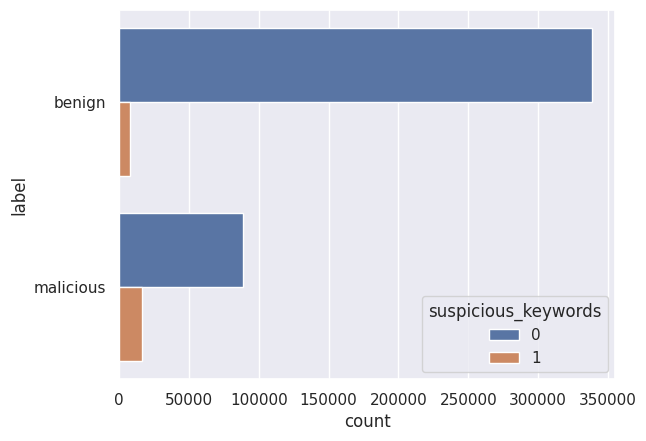

In [38]:
import seaborn as sns
sns.set(style='darkgrid')

a = sns.countplot(
    y='label',
    data=df,
    hue='suspicious_keywords')

#Ithupole ella featuresnteyum nokkanam... lexical type..

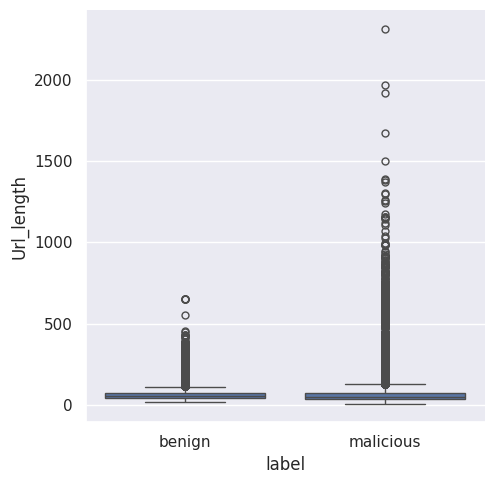

In [39]:
a = sns.catplot(
    x='label',
    data=df,
    y='Url_length',
    kind='box')

#Ithupole ella featuresm nokknm..Counting type ..

Label Encoding

In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['newlabel'] = le.fit_transform(df['label'])
df['newlabel'].value_counts()

#Need to check any problem with label encoding.......

0    345738
1    104438
Name: newlabel, dtype: int64

Features and Class separation

In [41]:
X = df[['HaveIP', 'abnormal_url', 'IsGoogleIndex', 'dot_count',
       'count_www', 'count_at', 'count_directory', 'redirection',
       'is_shortening_services', 'is_https', 'is_http', 'Url_length',
       'hostname_length', 'suspicious_keywords', 'count_digits',
       'firstDir_legth', 'tld_length', 'percentage', 'questionmark', 'hyphen',
       'equals']]
# Ella featuresm add cheyynm...Coloumn names

Y = df['newlabel']

In [42]:
Y.tail(10)

450166    1
450167    1
450168    1
450169    1
450170    1
450171    1
450172    1
450173    1
450174    1
450175    1
Name: newlabel, dtype: int64

In [43]:
X.columns

Index(['HaveIP', 'abnormal_url', 'IsGoogleIndex', 'dot_count', 'count_www',
       'count_at', 'count_directory', 'redirection', 'is_shortening_services',
       'is_https', 'is_http', 'Url_length', 'hostname_length',
       'suspicious_keywords', 'count_digits', 'firstDir_legth', 'tld_length',
       'percentage', 'questionmark', 'hyphen', 'equals'],
      dtype='object')

Training and Testing

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    stratify=Y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=123)


In [45]:
X_train

,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,...,Url_length,hostname_length,suspicious_keywords,count_digits,firstDir_legth,tld_length,percentage,questionmark,hyphen,equals
34364,0,1,1,1,1,0,2,0,0,1,...,48,20,0,0,4,3,0,0,0,0
438470,0,1,1,1,0,0,1,0,1,1,...,28,19,0,0,0,12,0,0,0,0
143370,0,1,1,1,1,0,5,0,0,1,...,73,14,0,0,6,3,0,0,1,0
235962,0,1,1,1,1,0,5,0,0,1,...,51,16,0,0,3,3,0,0,1,0
366468,0,1,1,1,0,1,7,0,0,0,...,180,14,1,0,2,3,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92979,0,1,1,1,1,0,2,0,0,1,...,55,20,0,0,4,3,0,1,0,1
443998,0,1,1,1,0,0,3,0,0,1,...,45,16,0,0,4,3,0,0,0,0
348600,0,1,1,1,0,0,4,0,0,0,...,68,31,1,0,7,2,0,0,1,0
39547,0,1,1,1,1,0,2,0,0,1,...,49,20,0,0,4,3,0,0,0,0


In [ ]:
#Url column drop cheyyanam

In [46]:
X_test

,HaveIP,abnormal_url,IsGoogleIndex,dot_count,count_www,count_at,count_directory,redirection,is_shortening_services,is_https,...,Url_length,hostname_length,suspicious_keywords,count_digits,firstDir_legth,tld_length,percentage,questionmark,hyphen,equals
223902,0,1,1,1,1,0,5,0,0,1,...,97,15,0,0,4,3,0,0,10,0
430026,0,1,1,1,0,0,3,0,0,0,...,75,12,1,0,10,3,0,1,1,0
60245,0,1,1,1,1,0,1,0,0,1,...,22,13,0,0,0,3,0,0,0,0
91277,0,1,1,1,1,0,1,0,0,1,...,50,22,0,0,12,3,0,1,0,1
106306,0,1,1,1,1,0,3,0,1,1,...,94,39,0,0,4,12,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173538,0,1,1,1,1,0,2,0,0,1,...,57,22,0,0,6,3,0,0,1,0
136897,0,1,1,1,1,0,1,0,0,1,...,187,14,0,0,1,3,13,1,1,4
105746,0,1,1,1,1,0,2,0,0,1,...,53,25,0,0,18,3,0,0,2,0
289909,0,1,1,1,1,0,1,0,1,1,...,40,17,0,0,14,3,0,0,0,0


In [47]:
Y_train

34364     0
438470    1
143370    0
235962    0
366468    1
         ..
92979     0
443998    1
348600    1
39547     0
422968    1
Name: newlabel, Length: 360140, dtype: int64

In [48]:
Y_test

223902    0
430026    1
60245     0
91277     0
106306    0
         ..
173538    0
136897    0
105746    0
289909    0
156661    0
Name: newlabel, Length: 90036, dtype: int64

Model Implementation

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,Y_train)

y_pred = rf.predict(X_test)

#X_testnu --> user url?

print(classification_report(Y_test,y_pred,target_names=['benign','malicious',]))

score = metrics.accuracy_score(Y_test,y_pred)

print("Accuracy : %f" % score)

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     69148
   malicious       1.00      0.99      0.99     20888

    accuracy                           1.00     90036
   macro avg       1.00      1.00      1.00     90036
weighted avg       1.00      1.00      1.00     90036

Accuracy : 0.997101


In [ ]:
#Check Other models and compare...

In [50]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,Y_train)
y_pred = lr.predict(X_test)
print(classification_report(Y_test,y_pred,target_names=['benign','malicious',]))

score = metrics.accuracy_score(Y_test,y_pred)

print("Accuracy : %f" % score)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     69148
   malicious       0.99      0.99      0.99     20888

    accuracy                           1.00     90036
   macro avg       0.99      0.99      0.99     90036
weighted avg       1.00      1.00      1.00     90036

Accuracy : 0.995613


In [ ]:
from sklearn.svm import SVC

sv = SVC(kernel='linear', C=1.0)

sv.fit(X_train,Y_train)
y_pred = sv.predict(X_test)
print(classification_report(Y_test,y_pred,target_names=['benign','malicious',]))

score = metrics.accuracy_score(Y_test,y_pred)

print("Accuracy : %f" % score)

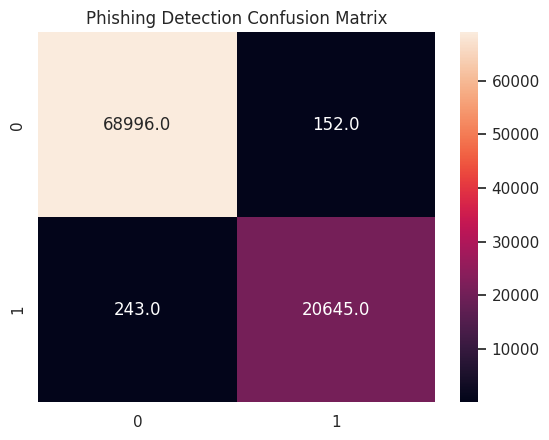

In [94]:
confmat = confusion_matrix(Y_test,y_pred)
confmat_df = pd.DataFrame(confmat,
                          index = ['benign','malicious'],
                          columns=['benign','malicious'])

plt.title("Phishing Detection Confusion Matrix")
plt.xlabel("Prediction values")
plt.ylabel("Actual values")
#plt.figure(figsize=(8,6))
sns.heatmap(confmat,
            annot=True,
            fmt=".1f")
plt.show()


Ee modelil  nalla importance tharunna features...

<Axes: >

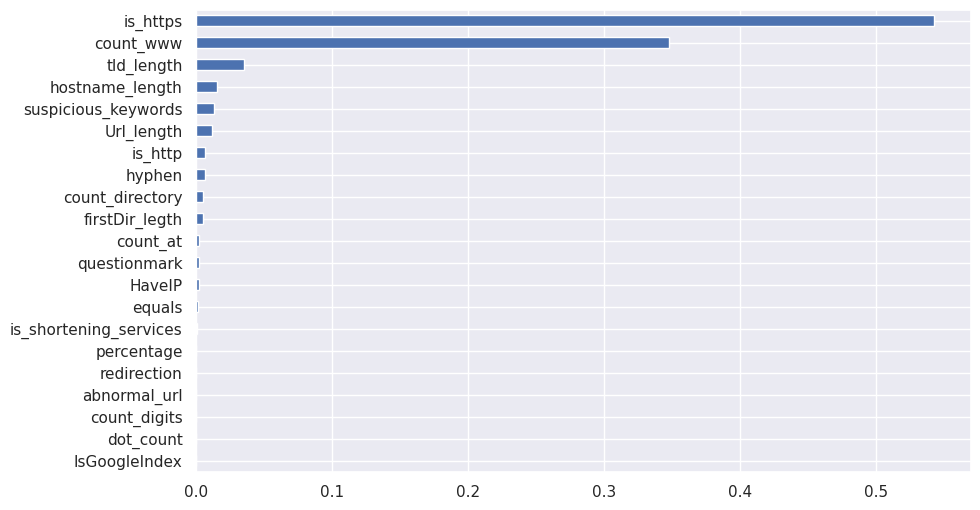

In [95]:
important_features = pd.Series(rf.feature_importances_,
                               index=X_train.columns)
important_features.sort_values().plot(kind='barh',
                                      figsize=(10,6))

Compare different models and find better one.. Or use pycaret..

**Prediction from user**

In [ ]:
def main(url):
  l = []

  '''HaveIP', 'abnormal_url', 'IsGoogleIndex', 'dot_count', 'count_www',
       'count_at', 'count_directory', 'redirection', 'is_shortening_services',
       'is_https', 'is_http', 'Url_length', 'hostname_length',
       'suspicious_keywords', 'count_digits', 'firstDir_legth', 'tld_length',
       'percentage', 'questionmark', 'hyphen', 'equals'''

  l.append(HaveIP(url))
  l.append(abnormal_url(url))
  l.append(IsGoogleIndex(url))
  l.append(dot_count(url))
  l.append(count_www(url))
  l.append(count_at(url))
  l.append(count_directory(url))
  l.append(redirection(url))
  l.append(is_shortening_services(url))
  l.append(is_https(url))
  l.append(is_http(url))
  l.append(Url_length(url))
  l.append(hostname_length(url))
  l.append(suspicious_keywords(url))
  l.append(count_digits(url))
  l.append(firstDir_legth(url))

  tld = get_tld(url,fail_silently=True)

  l.append(tld_length(tld))

  l.append(percentage(url))
  l.append(questionmark(url))
  l.append(hyphen(url))
  l.append(equals(url))

  return l

In [ ]:
def prediction(user_url):
  user_features = main(user_url)

  user_features = np.array(user_features).reshape((1,-1))

  prediction = model.predict(user_features)
  #Replace model with model object name

  if int(prediction[0]) == 0:
    return "Legitimate"
  else:
    return "Phishing"


In [ ]:
user_url = str(input("Enter url :: "))

print(prediction(user_url))